(lecture_20)=
# Horoscopes
:::{post} Jan 7, 2024
:tags: statistical rethinking, bayesian inference, scientific workflow
:category: intermediate
:author: Dustin Stansbury
:::

This notebook is part of the PyMC port of the [Statistical Rethinking 2023](https://github.com/rmcelreath/stat_rethinking_2023) lecture series by Richard McElreath.

[Video - Lecture 20 - Horoscopes](https://youtu.be/qwF-st2NGTU)# [Lecture 20 - Horoscopes](https://www.youtube.com/watch?v=qwF-st2NGTU)

In [1]:
# Ignore warnings
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import utils as utils
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats as stats

warnings.filterwarnings("ignore")

# Set matplotlib style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

# Horoscopes

This lecture mostly outlines a set of high-level heuristics and workflows to improve the quality of scientific research. Therefore there's not a lot of implementation details in the lecture to cover. I won't go through copying the content from each slide, but I cover some highlights (mostly for my own benefit) below:

## Statistics is like fortune telling

- Vague facts lead to vague advice
  - Reading tea leaves is like following common flow charts for statistical analysis
  - There's little scientific inputs, therefore little scientific interpretation
  - That's often the feature and the bug of fortune telling, and statistics:
    - by providing vague interpretations (e.g. horoscope predictions) from vague inputs (e.g. birthday), they can "explain" any number of outcomes
    - just like vague horoscopes can "explain" any number of possible future events
- Exaggerated importance
  - no one wants to hear evil portents in their tea leaves, just as no one wants to hear about NULL or negative statistical results
  - there's often incentive to use statistics to find the positive result
- It's often easier to offload subjective scientific responsibility onto objective statistical procedures

## Three pillars of scientific workflow
**1. Planning**
   - Goal setting
     - estimands
   - Theory building
     - assumptions
     - 4 types of theory building, increasing in specificity
       1. Heuristic (DAGs)
          - allows us to deduce a lot from establishing causal structure
       3. Structural
          - moves beyond DAGs by establishing specific functional forms of causes
       5. Dynamical models
          - usually work over spatial/temporal grid
          - tend to collapse large number of micro-states into macro interpretation
       7. Agent-based
          - focuses on individual micro states
   - Justified sampling
     - Which data do we use, and what's it's structure
     - Verify with simulation
   - Justified analysis
     - Which golems?
     - Can we recover estimands from simulations?
   - Documentation
     - How did it happen?
     - Help others and your future self
     - Scripting is self-documenting
         - Comments are important
         - Don't be clever, be explicit
           - Avoid clever one-liners
           - I find Python PEP useful here
   - Sharing
     - open source code and data formats
     - proprietary software does not facilitate shareing, and is bad scientific ethics
       - the irony here, is that MATLAB is so common in academic setting, particularly engineering 🙄
     - proprietery data formats can shoot you in the foot when you (or others) can no longer open them
  - Preregistration isn't a silver bullet
    - Pre-allocating expectations on a bad analysis approach (e.g. causal salad) doesn't fix the bad approach

**2. Working**

- Research engineering
  - Treat research more like software enginnering
  - standardized, battle-tested procedures that make software dependable and repeatable
    - version control (git)
    - testing
      - unit testing
      - integration testing
      - build up tests incrementally, validating each part of the workflow before proceeding to the next
    - documentation
    - review
      - 👀, 👀 have at least one other person review your analysis code and docs, and provide feedback
        - will often point out bugs, optimizations, or shortcomings in documentation
- Look at good examples
  - e.g. on of [McElreath's Consulting Projects](https://github.com/rmcelreath/CES_rater_2021/tree/main)
  - [Data Carpentry](https://datacarpentry.org/)

**3. Reporting**

- Sharing materials
  - by following code-based Working flow, sharing is pretty much done for you
  - [Nice breakdown and example of Describing Methods](https://youtu.be/qwF-st2NGTU?si=3I7CMalLXv3pIQhr&t=3742)
- Justify priors
- Justify methods, and dealing with reviewers
  - Common fallacy: "good scientific design doesn't require complex statistics"
    - valid causal modeling requires complexity
  - don't try to convince Reviewer 3 to accept your methods, write to editor
  - move the convo from statistical to causal modeling
- Describe data
  - structure
  - missing values: justify imputation if any
- Describe results
  - aim to report contrasts and marginal effects
  - use densities over intervals
  - avoid interpeting coefficients as causal effects
- Making decisions
  - this is often the goal (particularly in industry)
  - embrace uncertainty
    - uncertainty is not admission of weakness
  - Bayesian decision theory
    - use the posterior to simulate various policy interventions
    - can be used to provide posteriors to costs/benefits due to those interventions

## Scientific Reform

- many of the metrics for good science are counterproductive
  - e.g. papers that are least replicated continue to have higher citation count
  - META POINT: this result in publishing be explained using a causal modeling and colider bias
 
### Collider bias in scientific publishing

#### Causal model of collider bias

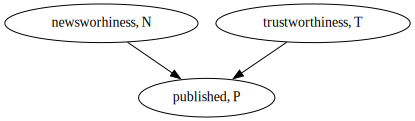

In [2]:
utils.draw_causal_graph(
    edge_list=[("newsworhiness, N", "published, P"), ("trustworthiness, T", "published, P")],
)

#### Simulating data from collider causal model

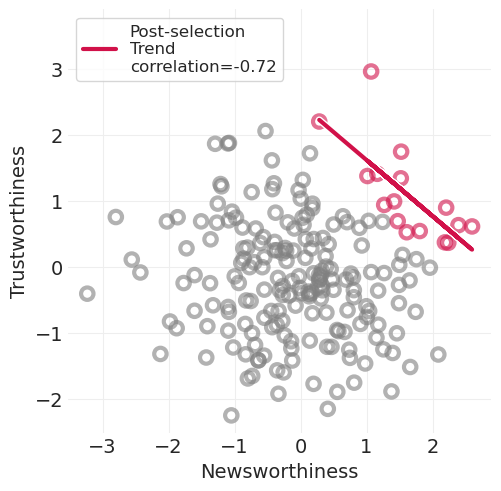

In [3]:
np.random.seed(123)
n_samples = 200

# N and T are independent
N = stats.norm.rvs(size=n_samples)
T = stats.norm.rvs(size=n_samples)

# Award criterion; either are large enough to threshold
A = np.where(N + T > 2, 1, 0)

for awarded in [0, 1]:
    color = "gray" if not awarded else "C0"
    N_A = N[A == awarded]
    T_A = T[A == awarded]
    utils.plot_scatter(N_A, T_A, color=color)

fit_data = pd.DataFrame({"N": N_A, "T": T_A})
cc = np.corrcoef(fit_data.T, fit_data.N)[0][1]
awarded_model = smf.ols("T ~ N", data=fit_data).fit()
utils.plot_line(
    N_A, awarded_model.predict(), color="C0", label=f"Post-selection\nTrend\ncorrelation={cc:0.2}"
)
plt.xlabel("Newsworthiness")
plt.ylabel("Trustworthiness")
plt.axis("square")
plt.legend();

By selecting at papers that are published based on a threshold that combines either newsworthiness--i.e. "sexy papers" that get cited a lot--or trustworthiness--i.e. boring papers that are replicable--we end up with highly-cited papers that tend to be less replicable.

## Horoscopes of research

- Many things that are "bad" about science (e.g. impact factor) are once well-intentioned reforms
- Some potential fixes are available:
  1. No stats before transparently-communicated causal model
     - avoid causal salad
  2. Prove your code/analysis works within the scope of your project and assumptions
  3. Share as much as possible
     - sometimes data is not shareable
     - but you can create partial, anonomized, or synthetic datasets
  4. Beware proxies for research quality (e.g. citation count, impact factor)

## Authors
* Ported to PyMC by Dustin Stansbury (2024)
* Based on Statistical Rethinking (2023) lectures by Richard McElreath

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Tue Dec 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
xarray  : 2024.7.0

scipy      : 1.14.1
xarray     : 2024.7.0
pymc       : 5.19.1
numpy      : 1.26.4
matplotlib : 3.9.2
statsmodels: 0.14.2
arviz      : 0.19.0
pandas     : 2.2.2

Watermark: 2.5.0



:::{include} ../page_footer.md
:::